In [1]:
from typing import Literal,Annotated, TypedDict, Union

from langchain_core.tools import tool
from langchain import hub
from langchain_core.messages import BaseMessage

from langchain_core.agents import AgentAction, AgentFinish
import operator

from langgraph.graph import END, START,StateGraph
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import ToolExecutor, ToolInvocation
from tools_helper import model,display,search
from langchain.agents import create_react_agent 

In [2]:
# 搜索工具

tool=search




In [3]:
# 工具绑定
tools= [search]
tool_executor = ToolExecutor(tools)
prompt = hub.pull("hwchase17/react")
model_with_tools   = create_react_agent(model, tools, prompt)
def run_agent(state):
    agent_outcome = model_with_tools.invoke(state)
    return {"agent_outcome": agent_outcome}

In [4]:
# 创建一个状态
class AgentState(TypedDict):
    input: str
    chat_history: list[BaseMessage]
    agent_outcome: Union[AgentAction, AgentFinish, None]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]


In [5]:
# 运行工具节点
def execute_tools(state):
    messages = [state["agent_outcome"]]
    last_message = messages[-1]
    tool_name = last_message.tool
    tool_input = last_message.tool_input
    action = ToolInvocation(
        tool=tool_name,
        tool_input= tool_input
    )
    response = tool_executor.invoke(action)
    return {"intermediate_steps": [(state["agent_outcome"], response)]}


In [6]:
graph = StateGraph(AgentState)
# 增加一个chatbot节点，具有工具调用功能
graph.add_node("chatbot", run_agent)
# 工具节点

graph.add_node("tools", execute_tools)
#增加一条边，从开始到chatbot，
graph.set_entry_point("chatbot")    
# 增加一条边，从工具回到chatbot，
graph.add_edge("tools", "chatbot")

In [7]:
# 从chatbot 发出一条条件边，根据情况到达工具节点或结束
def router(state):
    messages = [state["agent_outcome"]]
    last_message = messages[-1]
    if "Action"  in last_message.log:
        return "tools"
    else:
        return END
graph.add_conditional_edges("chatbot", router)

In [9]:
graph = graph.compile()

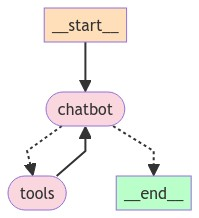

In [10]:
display(graph)

In [21]:

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    trytime=3
    while trytime>0:
        try:
            output= graph.invoke({"input": user_input, "chat_history": []})
            answer= output['agent_outcome'].log.split('Final Answer')[1]
            print(answer)
            break
        except Exception as e:
            print(e)
            trytime-=1
            print("Try again!")
    

    
               

: 北京的实时天气情况包括温度、风向、降水量等。根据气象站数据、网络摄像头信息，可以获取日出日落时间、当地风速和降水情况。您可以访问相关网站或应用来查询具体的10天预报或者未来15天的北京天气预报，以了解更详细的天气状况并做好出行准备。
: 苏州今天的天气为晴，气温范围在12℃到25℃之间，东风方向，总降水量0.00mm，相对湿度为59%。

交通指数良好：天气较好且路面干燥，适合车辆正常行驶。

旅游指数适宜：天气状况好，温度适宜，是个出行的好天。
: 这里有一些笑话供您欣赏：
1、办公室的小孙在食堂捡到了一个钱包。他拾金不昧，把钱包还给了失主——一个外籍员工。

2、表弟考上大学，是建工系，打电话跟我抱怨："班上一个女生也没有，太苦了。"我用实际工作经验告诉他："像你这个专业，不但没有女同学，将来上班了也会没有女同事。

3、蚂蚁：一个一年级的小朋友一回到教室就告诉教师："老师，厕所里有好多蚂蚁!"

4、晚上我跑完步有点口渴，就到路边摊买橘子，挑了几个卖相好的。老板又拿起几个有斑点的说："帅哥，这种长得不好看的其实更甜。"我颇有感悟地说："是因为橘子觉得自己长的不好看，所以努力让自己变得更甜吗？"

希望您喜欢这些笑话！
: 为什么数学书总是很安静？ 因为它有太多问题了（"question"谐音梗）。希望这个笑话能给你带来一丝笑容！


OutputParserException: Could not parse LLM output: `这个笑话可能好笑在于文化差异的理解。在中国，拾金不昧通常被视为一种高尚的品质，是被赞扬的行为。然而，在其他国家尤其是西方国家的实验中，丢钱包的“捡到者”通过这种方式测试当地人的诚信度时发现，“钱包回收率”相对较低，意味着人们更倾向于保留而非归还钱包。

因此，这个笑话可能基于这样一种情景：在办公室小孙将钱包归还给外籍员工的情况下，对西方文化背景下的预期进行对比。小孙的行为在中国社会中被视为典范，但在一些西方国家的实验背景下，这样的行为可能会被认为是不寻常或“好笑”的，因为这与他们对于诚信和道德的普遍期望有所违背。

简而言之，“笑话”可能在于这种文化差异的对比以及对中国人传统美德在国际语境下的幽默解读。`